- 保监会 分类模型 2 训练 

# 基本设置

In [1]:
##load packages, needed
# encoding=utf-8

import jieba
from jieba import analyse
import sys
import re
import time
import string
from sklearn import feature_extraction
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,mutual_info_classif,f_classif
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict

import pickle

%matplotlib inline
import numpy as np
import pandas as pd
import pre_cor
import dict_dbutils
import os
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
from pandas.io import sql
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.856 seconds.
Prefix dict has been built succesfully.


In [2]:
def set_ch():
    '''
    功能：设定绘图时显示中文
    '''	
    from pylab import mpl
    mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
    mpl.rcParams['axes.unicode_minus'] = False   # 解决保存图像是负号'-'显示为方块的问题
set_ch()

In [3]:
class StatsFeatures_cor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.neg = set()
        f = open("corpus/neg_words.txt","r+", encoding='UTF-8')
        for content in f:
            self.neg.add(content.strip())
        f.close()
        
        self.company = set() # 公司
        f = open("corpus/insurance_company_20180803.txt","r+", encoding='UTF-8')
        for content in f:
            self.company.add(content.strip())
        f.close()

        self.regulators = set() # 监管机构及领导
        f = open("corpus/insurance_regulators_20180804.txt","r+", encoding='UTF-8')
        for content in f:
            self.regulators.add(content.strip())
        f.close()    
        
        #初始化字典liwc
        self.liwc = {} 
        f2 = open("corpus/scliwc.txt",'r', encoding = 'gb18030')
        for ii in f2:     #ii在scliwc.txt中循环
            i = ii.strip().split() 
            self.liwc[i[0]] = i[1:len(i)]
        f2.close      
        
        self.category = set()
        for i in list(self.liwc.values()):
            for j in i:
                self.category.add(j)         
        
    def fit(self, X, y=None):
        return self

    def getcnt(self,x):        
        return len(list(set(x)))

    def getnegcnt(self,x):
        negcnt = 0
        words = x.split()
        for w in words:
            if w in self.neg:
                negcnt = negcnt+1
        return negcnt
    
    def getorgcnttf(self,x):
        companycnt=0
        companytf=0
        regcnt = 0
        regtf = 0
        
        words = x.split()
        words_set=set(words)
        for w in words_set:
            if w in self.company:
                companycnt = companycnt+1
                companytf=companytf+words.count(w)
                
            if w in self.regulators:
                regcnt = regcnt+1
                regtf=regtf+words.count(w)            
                
        return companycnt, companytf, regcnt, regtf
    
    def transform(self, X):
        data = []
        for x in X:
            if len(x) == 0:
                length  = 1
            else :
                length = len(x)
                
            companycnt, companytf, regcnt, regtf=self.getorgcnttf(x)
            
#             words = x.split()
#             psy = []
#             for w in words:
#                 if w in self.liwc: #是否liwc字典包含分词结果列表words的哪些分词
#                     psy += self.liwc[w] 
            
#             cat_tf = []
#             for cat in self.category:
#                 cat_tf.append(psy.count(cat)) 
                
            data.append([len(x),self.getcnt(x),self.getcnt(x)/length,
                         self.getnegcnt(x),self.getnegcnt(x)/length,
                         companycnt, companytf, regcnt, regtf]) #  + cat_tf            
        return data

In [4]:
def getkeywords(X, N = 1000):
    '''
    训练时生成，合并所有记录，取N个关键词
    '''
    textrank = analyse.textrank

    text_combined = ' '.join(X)
    keywords = textrank(text_combined, topK = N)
    print('keywords num: ', len(keywords))
    if len(keywords) < N : 
        N  = len(keywords)

    if keywords:
        f = open("corpus/keywords.txt","w+", encoding='UTF-8')
        for content in keywords:
            content = content.strip()
            f.write(content + '\n')
        f.close()

In [5]:
class Statskeywords(BaseEstimator, TransformerMixin):
    
    def __init__(self, topk = 100):
        self.topk = topk
        
        self.keywords = set()
        f = open("corpus/keywords.txt","r+", encoding='UTF-8')
        num = 0
        for content in f:
            if num < topk:
                self.keywords.add(content.strip().replace('\n', ''))
            num += 1
        f.close() 
                
#         self.otherwords = ['保险业','保险行业','保费','险资','险企', # 行业
#                            '罚款', # 公司 
#                            '产品', '销售', '投保', '保单', '续保', # 产品
#                            '投诉','骗保','案例','快速理赔','快赔','赔付', # 消费
#                            '个股','港股','股市','股票','大盘','目标价','评级', # 资本
#                            '活动','扶贫','奖','批复' # 其他
#                           ]
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        '''
        文本中关键词的词频
        '''                        
        data = []
        for x in X:
            words = x.split()
            word_tf = []
            keycnt = 0
            for kw in self.keywords:
                word_tf.append(words.count(kw)) # 各个关键词的词频
                if kw in words:keycnt+=1
            word_tf.append(keycnt) # 关键词的个数
            
#             tw_tf = []
#             for tw in self.otherwords:
#                 tw_tf.append(words.count(tw))               
                
            data.append(word_tf ) # + tw_tf            
        return data        

## 上一版模型读入

In [6]:
# 上一版模型
from sklearn.externals import joblib
pipeline_old = joblib.load( "model/circ_8classifier_0815.pkl.z") 

# 导入数据

In [7]:
title = []
filename = 'data/titles1.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    title.append(f.strip().replace('\n', ''))
fid.close()
print(len(title))

14175


In [8]:
title[:2]

['中华保险 因未 按规定 报送 可疑交易 报告 遭 央行 罚 万', '中国人寿 北京 违法 欺骗 投保人 保险 金融 频道 首页 财经网']

In [9]:
content = []
filename = 'data/contents1.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    content.append(f.strip().replace('\n', ''))
fid.close()
print(len(content))
# content[:2]

14175


In [10]:
title_content = [t + ' ' + c for t,c in zip(title, content)]
print(len(title_content))

14175


In [11]:
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}
class_name_dict = {v: k for k, v in label_dic.items()}
class_name_dict

{1: '监管',
 2: '行业',
 3: '产品销售',
 4: '资本市场',
 5: '公司内部管理',
 6: '消费服务',
 7: '其他相关报道',
 8: '噪音'}

In [12]:
label = []
filename = 'data/labels.txt'
fid = open(filename, "r+", encoding='UTF-8')
for f in fid:
    label.append(f.strip().replace('\n', ''))
fid.close()
print(len(label))
label[:5]

14175


['公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理', '公司内部管理']

In [13]:
label = [label_dic[l] for l in label]
label[:5]

[5, 5, 5, 5, 5]

# 训练模型

## 分割训练集、测试集

In [14]:
X_train, X_test, y_train, y_test = train_test_split(title_content, label, test_size=0.3, random_state=42)
print('训练集：',len(y_train))
print('训练集-各类数量：',Counter(y_train))
print('测试集：',len(y_test))
print('测试集-各类数量：',Counter(y_test))

训练集： 9922
训练集-各类数量： Counter({8: 2776, 1: 1273, 2: 1245, 5: 1154, 7: 1133, 6: 1125, 4: 705, 3: 511})
测试集： 4253
测试集-各类数量： Counter({8: 1220, 1: 541, 2: 510, 7: 501, 5: 496, 6: 482, 4: 287, 3: 216})


# xgboost

## feature

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("Set2", 8)

In [24]:
def plot2(features):
    % matplotlib inline

    f = plt.figure(figsize=(15, 9))
    ax = f.add_subplot(111)

    for i in range(1,9):
        ax.scatter(features[features['label']==i]['f1'],
                   features[features['label']==i]['f2'],
                   color=colors[i-1], label=i, alpha=.8) 
    
    ax.set_title("Truncated SVD, 2 Components")    
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    print(class_name_dict)
    
    plt.show()

In [25]:
def plot3(features):    
    % matplotlib notebook

    f = plt.figure(figsize=(15, 9))
    ax = f.add_subplot(111, projection='3d')  # 创建一个三维的绘图工程

    for i in range(1,9):
        ax.scatter(features[features['label']==i]['f1'],
                   features[features['label']==i]['f2'],
                   features[features['label']==i]['f3'],
                   color=colors[i-1], label=i, alpha=.8)

    ax.set_zlabel('f3')  # 坐标轴
    ax.set_ylabel('f2')
    ax.set_xlabel('f1')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    print(class_name_dict)

    plt.show()

In [26]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

## 计算特征

### scaled

In [92]:
combined_features = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
       ('len_stats', StatsFeatures_cor())
    ])),
   ('standard', StandardScaler(with_mean=False))
])

X_features = combined_features.fit(X_train, y_train).transform(X_train)
# print(X_features)

X_features_dense = DenseTransformer().fit_transform(X_features)
print(X_features_dense.shape)
print(type(X_features_dense))
# X_features_dense[:,0].shape
X_features_dense[:5,:5]

  (0, 12)	2.1681234866063934
  (0, 20)	3.1483067290538025
  (0, 25)	1.2619230187360284
  (0, 44)	0.8767515948537857
  (0, 93)	2.3852615028327864
  (0, 103)	1.4286588120584478
  (0, 108)	1.2532997247091011
  (0, 109)	11.9899043853986
  (0, 116)	0.21796165032249265
  (0, 154)	1.1594127565543737
  (0, 178)	2.579440297083105
  (0, 200)	0.28381654574183557
  (0, 230)	0.44977898803299116
  (0, 234)	1.569027561072947
  (0, 251)	1.0333232043938676
  (0, 265)	4.778983261389366
  (0, 269)	1.7688934934729115
  (0, 272)	1.1494159283389058
  (0, 318)	0.21978007852121387
  (0, 324)	9.23882384961702
  (0, 325)	4.8240543496154995
  (0, 327)	0.5862952532876115
  (0, 328)	4.01395314116369
  (0, 333)	21.170301290637276
  (0, 347)	0.31038928147559236
  :	:
  (7787, 2525)	1.0834878386512485
  (7787, 2528)	0.1676333675353508
  (7787, 2529)	0.11744873501402427
  (7787, 2532)	0.42148465651891914
  (7787, 2534)	0.07579441419099033
  (7787, 2545)	0.0887567886199212
  (7787, 2546)	0.3852138140581949
  (7787, 254

(7788, 1)

In [133]:
X_features_dense[:5,:20]

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  2.16812349,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        , 25.74143047],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        , 

### unscaled

In [105]:
combined_features_unscaled = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=2000))
        ])),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
       ('len_stats', StatsFeatures_cor())
    ])),
   # ('standard', StandardScaler(with_mean=False))
])

X_features_unscaled = combined_features_unscaled.fit(X_train, y_train).transform(X_train)
# print(X_features)

X_features_dense_unscaled = DenseTransformer().fit_transform(X_features_unscaled)
print(X_features_dense_unscaled.shape)
print(type(X_features_dense_unscaled))
X_features_dense_unscaled[:5,:20]

(7788, 2580)
<class 'numpy.matrixlib.defmatrix.matrix'>


matrix([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [134]:
X_features_dense_unscaled[:5,:20]

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.06385404, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.13334058],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        

## 特征可视化

### TruncatedSVD, SparsePCA, PCA

#### scaled

In [93]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 3) # 处理稀疏数据
feature_tsvd = tsvd.fit_transform(X_features)
print('-- TruncatedSVD: ')
print("各维度的方差值: ", tsvd.explained_variance_)
print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd.shape)
print()
pca = PCA(n_components = 3, whiten = True)
feature_pca = pca.fit_transform(X_features_dense)
print('-- PCA: ')
print("各维度的方差值: ", pca.explained_variance_)
print("各维度的方差值占总方差值的比例: ", pca.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(pca.explained_variance_ratio_))
feature_pca

-- TruncatedSVD: 
各维度的方差值:  [47.98878057 51.28708936 51.82124439]
各维度的方差值占总方差值的比例:  [0.01862196 0.01990186 0.02010914]
各维度的方差值之和占总方差值的比例:  0.05863295084079169
(7788, 3)

-- PCA: 
各维度的方差值:  [68.29161858 52.140681   49.84855393]
各维度的方差值占总方差值的比例:  [0.02649703 0.0202305  0.01934115]
各维度的方差值之和占总方差值的比例:  0.0660686802446935


array([[ 0.8998379 , -0.24924554, -0.13594546],
       [-1.12628996, -2.65245224,  6.7268864 ],
       [-0.6451367 ,  0.03649575, -0.36151828],
       ...,
       [-0.65211979,  0.13414206, -0.4065679 ],
       [ 0.18311423,  1.49569724,  0.30770069],
       [-0.27817648, -0.18781407, -0.28180242]])

         f1        f2        f3  label
0  0.899838 -0.249246 -0.135945      8
1 -1.126290 -2.652452  6.726886      5
2 -0.645137  0.036496 -0.361518      3
3 -0.725728  0.082057 -0.433858      6
4  1.240497 -0.244461  0.435929      2
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


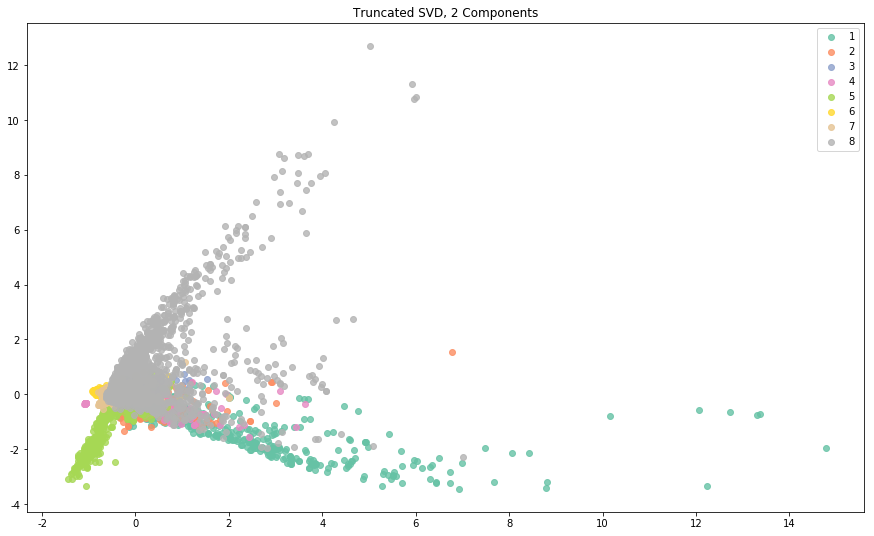

In [123]:
features = pd.DataFrame(feature_pca, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


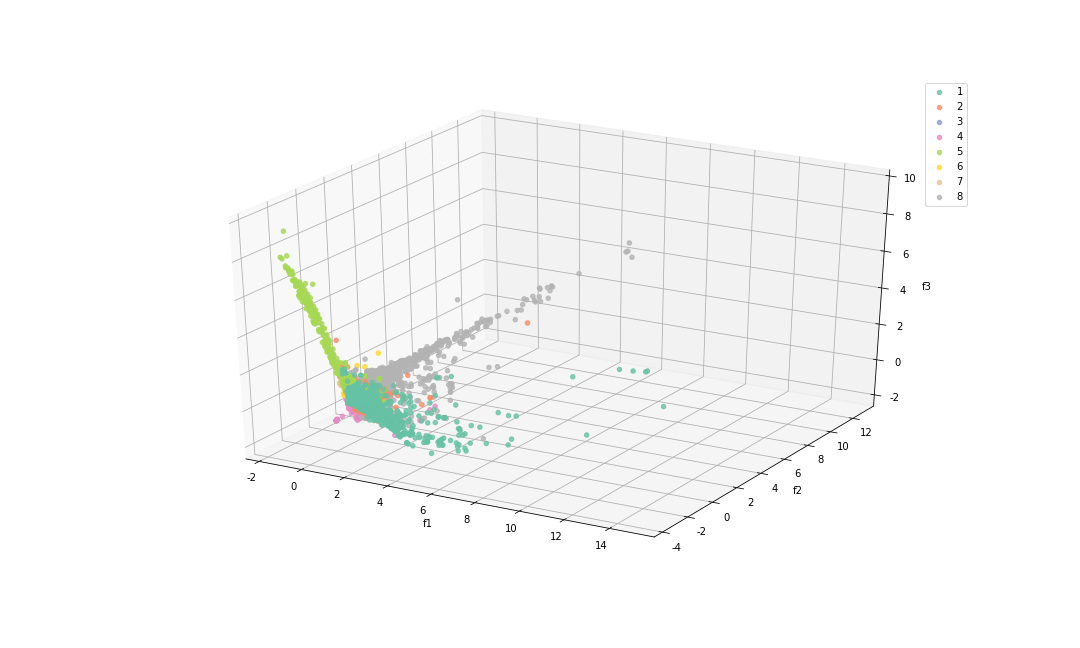

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [104]:
plot3(features)

#### unscaled

In [116]:
from sklearn.decomposition import TruncatedSVD, SparsePCA, PCA

tsvd = TruncatedSVD(n_components = 3) # 处理稀疏数据
feature_tsvd_unscaled = tsvd.fit_transform(X_features_unscaled)
print('-- TruncatedSVD: ')
print("各维度的方差值: ", tsvd.explained_variance_)
print("各维度的方差值占总方差值的比例: ", tsvd.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(tsvd.explained_variance_ratio_))
print(feature_tsvd_unscaled.shape)
print()
pca = PCA(n_components = 3, whiten = True)
feature_pca_unscaled = pca.fit_transform(X_features_dense_unscaled)
print('-- PCA: ')
print("各维度的方差值: ", pca.explained_variance_)
print("各维度的方差值占总方差值的比例: ", pca.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(pca.explained_variance_ratio_))
feature_pca_unscaled

-- TruncatedSVD: 
各维度的方差值:  [6.05064133e+06 2.22405572e+04 4.33829524e+03]
各维度的方差值占总方差值的比例:  [9.94178305e-01 3.65433650e-03 7.12823447e-04]
各维度的方差值之和占总方差值的比例:  0.9985454651486427
(7788, 3)

-- PCA: 
各维度的方差值:  [6.05990629e+06 1.39861175e+04 4.29191371e+03]
各维度的方差值占总方差值的比例:  [9.95572776e-01 2.29775795e-03 7.05111967e-04]
各维度的方差值之和占总方差值的比例:  0.9985756455507602


array([[ 0.67222096, -1.17172305,  1.10364705],
       [-0.35151865,  0.41289396,  0.04782782],
       [-0.63532545,  1.36957597, -0.2889419 ],
       ...,
       [-0.4585727 ,  0.15310337,  0.30226441],
       [ 1.09698944, -1.91447454, -2.00706747],
       [-0.32808277,  0.12135384,  0.04299659]])

         f1        f2        f3  label
0  0.672221 -1.171723  1.103647      8
1 -0.351519  0.412894  0.047828      5
2 -0.635325  1.369576 -0.288942      3
3 -0.453511  0.275113 -0.092596      6
4  1.713288  1.055719  1.499045      2
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


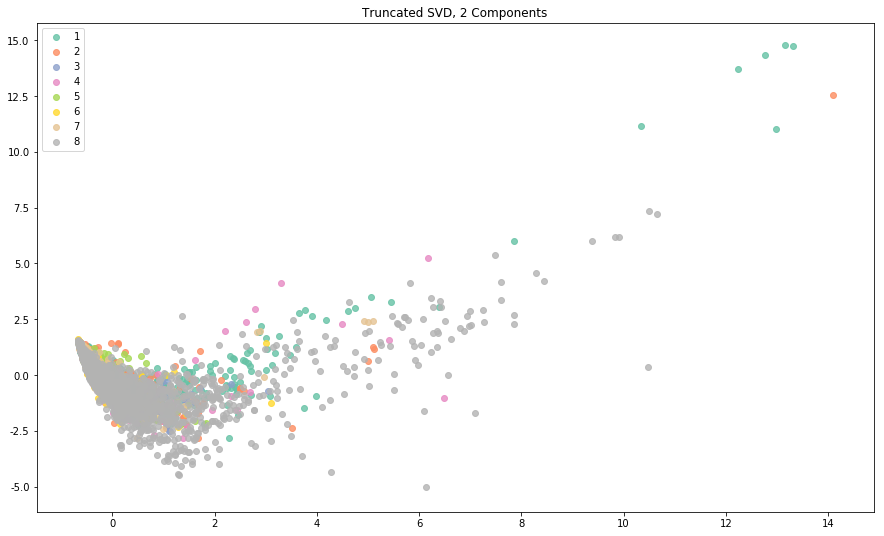

In [124]:
features = pd.DataFrame(feature_pca_unscaled, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


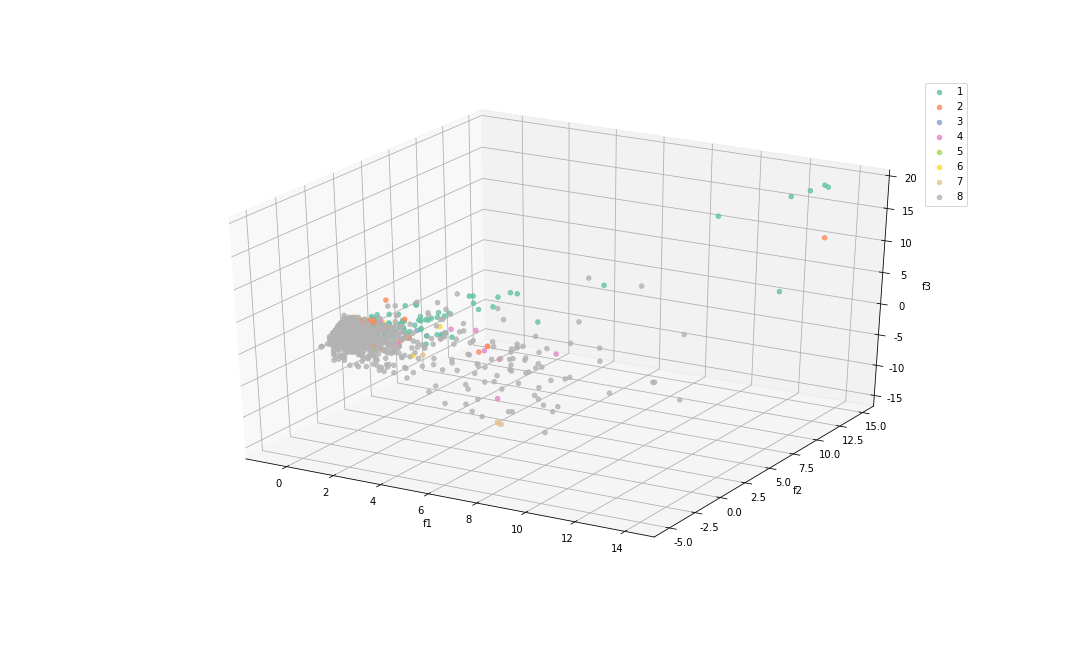

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


In [122]:
plot3(features)

### lda

#### scaled

In [129]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_features_dense, y_train)
feature_lda = lda.transform(X_features_dense)

print('-- lda: ')
print(feature_lda.shape)
# print("截距: ", lda.intercept_)
# print("系数: ", lda.coef_)
print("各维度的方差值占总方差值的比例: ", lda.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(lda.explained_variance_ratio_))
feature_lda

-- lda: 
(7788, 3)
各维度的方差值占总方差值的比例:  [0.22572378 0.1873764  0.1618737 ]
各维度的方差值之和占总方差值的比例:  0.5749738727726336


array([[ 0.74788493,  2.27976034, -0.66611544],
       [ 0.93666944,  0.71478887,  1.88996009],
       [ 1.21274736,  0.22894026, -0.64798034],
       ...,
       [ 4.95659989, -4.3085913 , -3.04990277],
       [ 0.17125421,  0.78558141,  0.114646  ],
       [ 2.21984253,  0.20668871,  0.28531425]])

         f1        f2        f3  label
0  0.747885  2.279760 -0.666115      8
1  0.936669  0.714789  1.889960      5
2  1.212747  0.228940 -0.647980      3
3  5.153940 -6.017474 -3.451951      6
4 -1.694149  1.157774 -1.327851      2
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


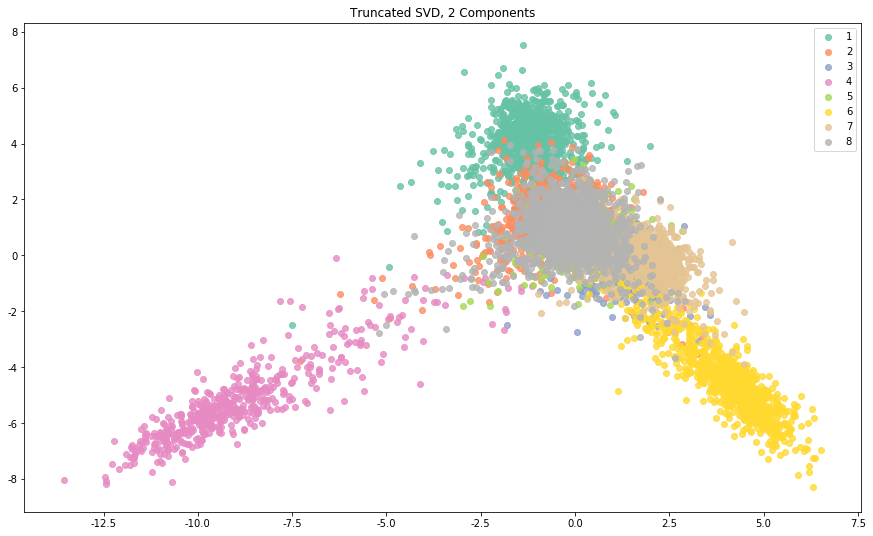

In [130]:
features = pd.DataFrame(feature_lda, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


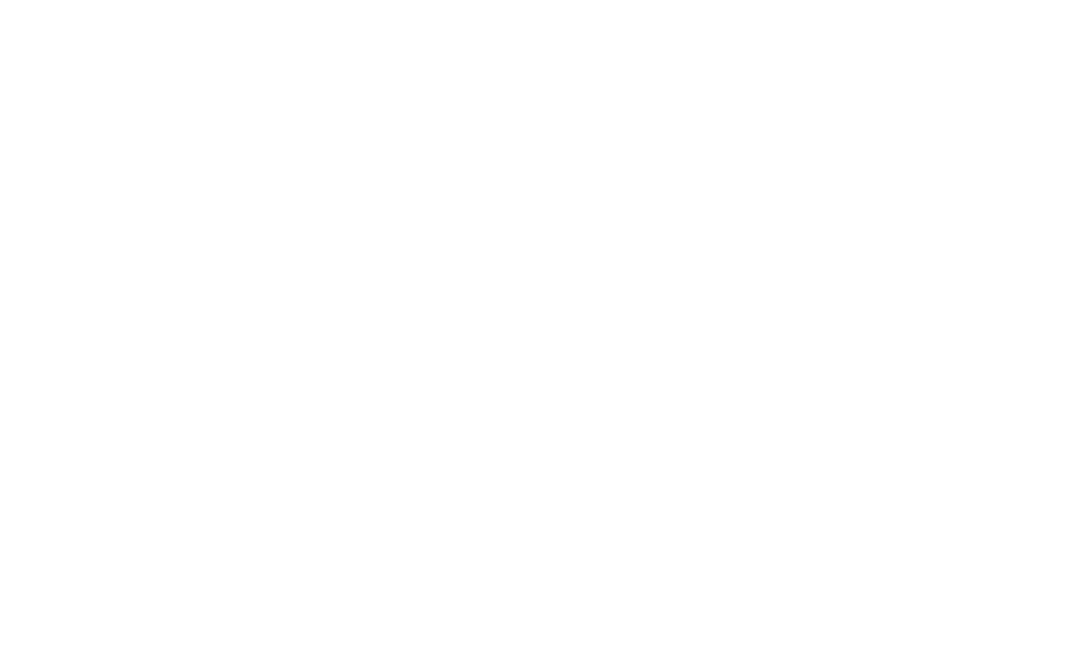

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


<IPython.core.display.Javascript object>


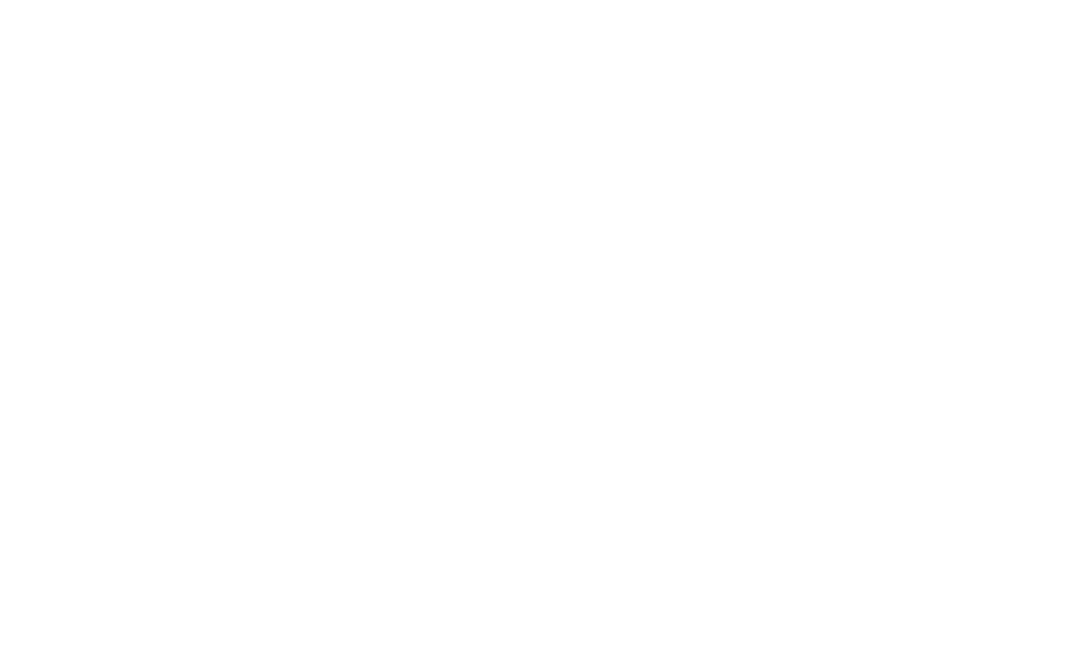

In [131]:
plot3(features)

#### unscaled

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=3)
lda.fit(X_features_dense_unscaled, y_train)
feature_lda_unscaled = lda.transform(X_features_dense_unscaled)

print('-- lda: ')
print(feature_lda_unscaled.shape)
# print("截距: ", lda.intercept_)
# print("系数: ", lda.coef_)
print("各维度的方差值占总方差值的比例: ", lda.explained_variance_ratio_) 
print("各维度的方差值之和占总方差值的比例: ", np.sum(lda.explained_variance_ratio_))
feature_lda_unscaled

-- lda: 
(7788, 3)
各维度的方差值占总方差值的比例:  [0.22572378 0.1873764  0.1618737 ]
各维度的方差值之和占总方差值的比例:  0.5749738727726332


array([[ 0.74788493,  2.27976034, -0.66611544],
       [ 0.93666944,  0.71478887,  1.88996009],
       [ 1.21274736,  0.22894026, -0.64798034],
       ...,
       [ 4.95659989, -4.3085913 , -3.04990277],
       [ 0.17125421,  0.78558141,  0.114646  ],
       [ 2.21984253,  0.20668871,  0.28531425]])

         f1        f2        f3  label
0  0.747885  2.279760 -0.666115      8
1  0.936669  0.714789  1.889960      5
2  1.212747  0.228940 -0.647980      3
3  5.153940 -6.017474 -3.451951      6
4 -1.694149  1.157774 -1.327851      2
{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


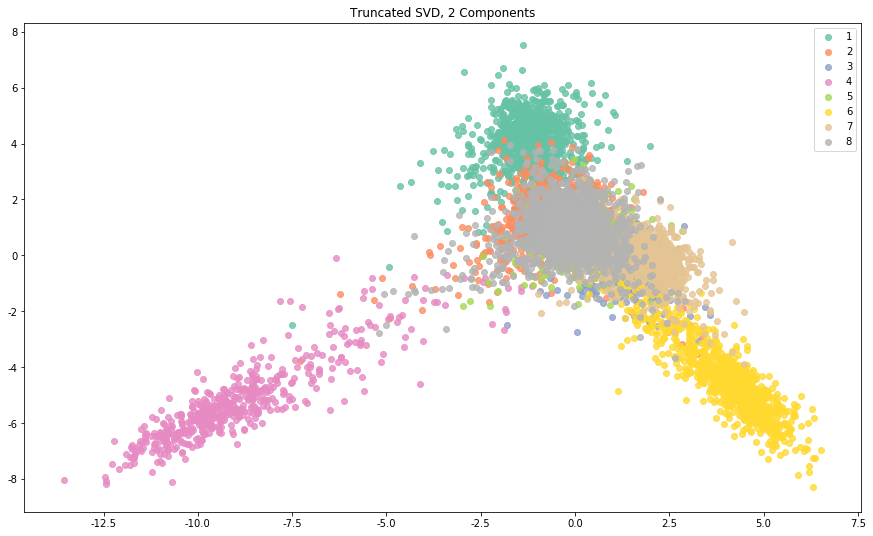

In [127]:
features = pd.DataFrame(feature_lda_unscaled, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

<IPython.core.display.Javascript object>


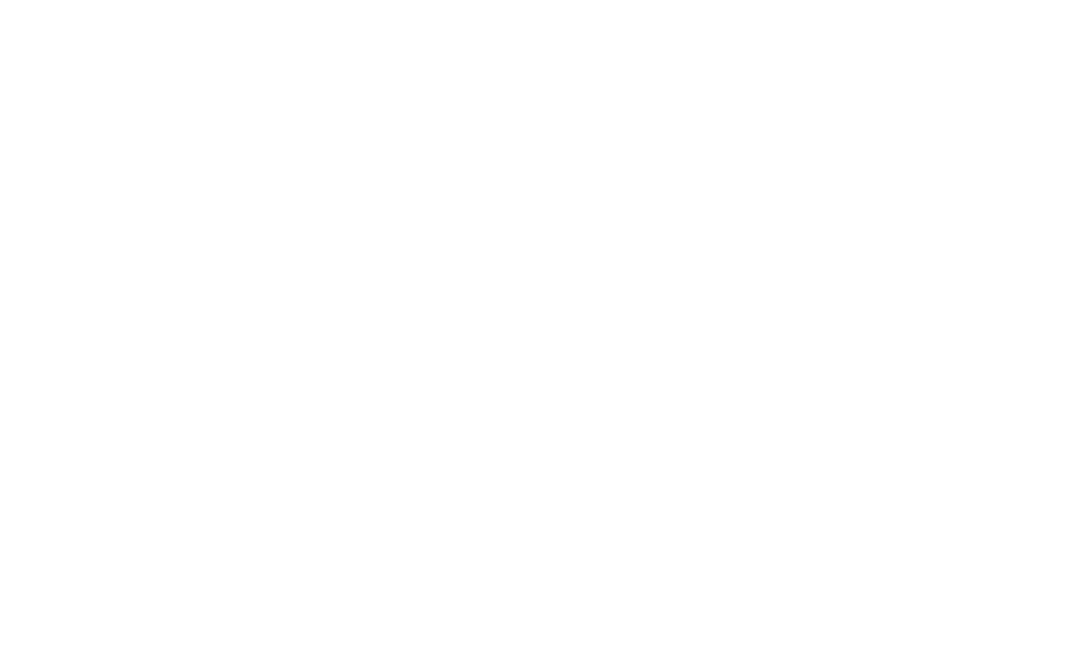

{1: '监管', 2: '行业', 3: '产品销售', 4: '资本市场', 5: '公司内部管理', 6: '消费服务', 7: '其他相关报道', 8: '噪音'}


<IPython.core.display.Javascript object>


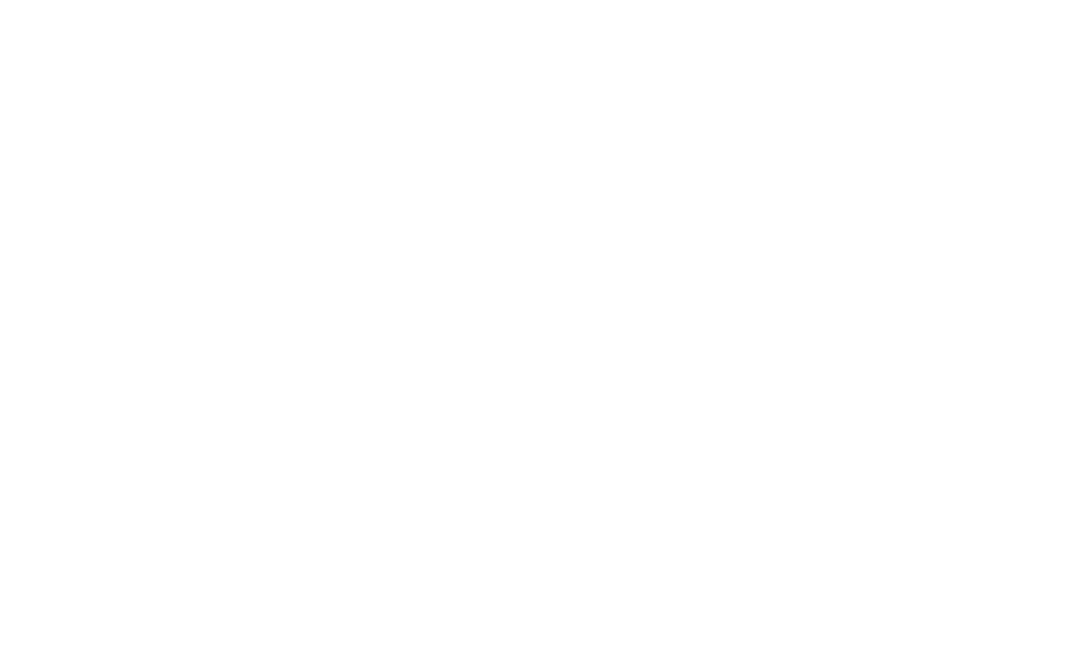

In [128]:
plot3(features)

### TSNE
- tsne 保留下的属性信息，更具代表性，也即最能体现样本间的差异；
- TSNE 运行极慢，PCA 则相对较快；
- 因此更为一般的处理，尤其在展示（可视化）高维数据时，常常先用 PCA 进行降维，再使用 tsne
> - data_pca = PCA(n_components=50).fit_transform(data)
> - data_pca_tsne = TSNE(n_components=2).fit_transform(data_pca)

In [ ]:
from sklearn.manifold import TSNE

feature_tsne = TSNE(n_components=2,learning_rate=100).fit_transform(X_features_dense)

In [ ]:
features = pd.DataFrame(feature_lda_unscaled, columns = ['f1', 'f2', 'f3'])
features['label'] = y_train
print(features.head())
features.describe()

plot2(features)

## 特征重要性

In [137]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    total = array(imp_dict.values()).sum()
    return {k:v/total for k,v in imp_dict.items()}

In [23]:
# feat_names = [str(i) for i in range(9)]
# get_xgb_imp(pipeline,feat_names)

In [139]:
# from xgboost import plot_importance

In [22]:
# %matplotlib inline

# fig,ax = plt.subplots(figsize=(15,15))
# plot_importance(Pipeline,
#                  height=0.5,
#                 ax=ax,
#                 max_num_features=64)
# plt.show()

## train

In [67]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures_cor()),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9955792132804042


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...tate=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1))])

## test

In [68]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8650793650793651
             precision    recall  f1-score   support

          1       0.83      0.86      0.85       380
          2       0.83      0.78      0.80       370
          3       0.83      0.72      0.77       132
          4       0.83      0.83      0.83       201
          5       0.85      0.87      0.86       352
          6       0.88      0.95      0.91       298
          7       0.93      0.89      0.91       351
          8       0.89      0.90      0.89       688

avg / total       0.86      0.87      0.86      2772

confusion_matrix: 
[[327  21   0   7   3   1   3  18]
 [ 22 287   8   7  10   9   5  22]
 [  3   9  95   0   4   7   5   9]
 [  4   5   1 167  12   0   1  11]
 [  2  17   3   8 306   8   3   5]
 [  0   3   3   0   3 282   1   6]
 [  5   1   2   1  16   5 312   9]
 [ 30   4   3  10   7   7   5 622]]


In [37]:
# 上一版模型 
y_pred_class = pipeline_old.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8839732888146912
             precision    recall  f1-score   support

          1       0.85      0.88      0.87       451
          2       0.82      0.79      0.81       359
          3       0.92      0.79      0.85       205
          4       0.88      0.83      0.85       256
          5       0.84      0.84      0.84       342
          6       0.91      0.95      0.93       482
          7       0.92      0.92      0.92       443
          8       0.90      0.92      0.91      1056

avg / total       0.88      0.88      0.88      3594

confusion_matrix: 
[[399  18   2   2   5   0   2  23]
 [ 24 283   5   5  10   7   4  21]
 [  3   4 162   3   5  13   6   9]
 [  5   6   0 213   9   0   3  20]
 [  1  18   1   4 287   9  11  11]
 [  0   3   2   1   5 457   4  10]
 [  2   4   0   0  11   6 407  13]
 [ 36   8   4  15   9  10   5 969]]


## PRC and ROC

In [32]:
from sklearn.preprocessing import label_binarize, OneHotEncoder

X = np.array(title_content)
Y = np.array(label)

# Use label_binarize to be multi-label like settings
# Y = label_binarize(label, classes=range(1,9))
# n_classes = Y.shape[1]
# print(n_classes)

Y = OneHotEncoder(sparse = False).fit_transform(Y.reshape(-1,1))

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

MemoryError: 

In [16]:
from sklearn.multiclass import OneVsRestClassifier

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('len_stats', StatsFeatures_cor()),
        ('tf', Pipeline([
            ('tf_k', Statskeywords(topk = 5000)),
            ('chi', SelectKBest(chi2, k=500))])),
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', OneVsRestClassifier(XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8)))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
print(pipeline)

# y_score = pipeline.decision_function(X_test)
# y_score = pipeline.predict_proba(X_test)

0.9909361955873583
Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
          n_jobs=1))])


In [17]:
y_pred_class = pipeline.predict(X_test)

test_auc2 = metrics.roc_auc_score(y_test,y_pred_class)#验证集上的auc值
print ("xgb_muliclass_auc:",test_auc2)

xgb_muliclass_auc: 0.8882394803183891


### PRC

In [ ]:
# The average precision score in multi-label settings
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

In [ ]:
# Plot the micro-averaged Precision-Recall curve
% matplotlib inline
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'
          .format(average_precision["micro"]))

In [ ]:
# Plot Precision-Recall curve for each class and iso-f1 curves
% matplotlib inline
from itertools import cycle
import seaborn as sns

colors = sns.color_palette("Set2", 8)
# setup plot details
# colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

plt.show()

### ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# Plot of a ROC curve for a specific class

% matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Plot ROC curves for the multiclass problem
# Compute macro-average ROC curve and ROC area

% matplotlib inline
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## 模型解释

## KFold

In [69]:
cir_data_raw = pd.read_excel('data/result/title_content_label.xlsx')
raw_title = np.array(cir_data_raw['title'])
raw_content = np.array(cir_data_raw['content'])
print(cir_data_raw.shape)
cir_data_raw.head()

(13856, 5)


,label,title,content,title_content,index
0,公司内部管理,中华保险因未按规定报送可疑交易报告等遭央行罚9万,中华保险因未按规定报送可疑交易报告等遭央行罚9万\n\r2018.01.04 09:17:...,中华保险因未按规定报送可疑交易报告等遭央行罚9万。 中华保险因未按规定报送可疑交易报告等遭央...,0
1,公司内部管理,中国人寿北京违法欺骗投保人_保险_金融频道首页_财经网,中国经济网北京1月2日讯北京保监局于2017年12月27日对中国人寿保险股份有限公司北京市...,中国人寿北京违法欺骗投保人_保险_金融频道首页_财经网。 中国经济网北京1月2日讯北京保监局...,1
2,公司内部管理,中国人寿北京市分公司因欺骗投保人被保监局罚款30万元,中国人寿\n\r北京市分公司因欺骗投保人被保监局罚款30万元\n\r千龙网北京1月2日讯 ...,中国人寿北京市分公司因欺骗投保人被保监局罚款30万元。 中国人寿\n\r北京市分公司因欺骗投...,2
3,公司内部管理,中国人寿|北京保监局_新浪财经_新浪网,中国经济网北京1月2日讯 北京保监局于2017年12月27日对\n\r中国人寿\n\r...,中国人寿|北京保监局_新浪财经_新浪网。 中国经济网北京1月2日讯 北京保监局于2017...,3
4,公司内部管理,中国人保分公司涉嫌编制虚假报告 被保监会罚款27万,中国人保分公司涉嫌编制虚假报告 被保监会罚款27万\n\r1\n评论\n\r2018-01...,中国人保分公司涉嫌编制虚假报告 被保监会罚款27万。 中国人保分公司涉嫌编制虚假报告 被保监...,4


In [70]:
from sklearn.model_selection import KFold
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=0)
title_content = np.array(title_content)
label = np.array(label)

In [71]:
kfold_res = {'raw_title':[], 'raw_content':[], 'label':[], 
             'predict_label':[], 'title_content':[], 'predict_proba':[]}
kfold_res

{'raw_title': [],
 'raw_content': [],
 'label': [],
 'predict_label': [],
 'title_content': [],
 'predict_proba': []}

In [72]:
num = 0
for train_index , test_index in kf.split(title_content):
    print('---- %s'%(num+1))
    X_train,X_test = title_content[train_index], title_content[test_index]
    y_train,y_test = label[train_index], label[test_index]
    
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('tf_idf', Pipeline([
                ('counts', CountVectorizer(max_df=0.95, min_df=2)),
                ('tf_idf', TfidfTransformer()),
                ('chi', SelectKBest(chi2, k=20000))
            ])),
            ('len_stats', StatsFeatures_cor()),
            ('tf', Pipeline([
                ('tf_k', Statskeywords(topk = 5000)),
                ('chi', SelectKBest(chi2, k=500))])),
        ])),
        ('standard', StandardScaler(with_mean=False)),
        ('classifier', XGBClassifier(max_depth=7,objective='multi:softmax', num_class=8))
    ])
    
    pipeline.fit(X_train, y_train)
    print(pipeline.score(X_train, y_train))    
    
    y_pred_class = pipeline.predict(X_test)
    print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
    print(metrics.classification_report(y_test, y_pred_class))
    print('confusion_matrix: ')
    print( metrics.confusion_matrix(y_test, y_pred_class))    
    
    y_pred_prob = pipeline.predict_proba(X_test)
    
    kfold_res['raw_title'] += list(raw_title[test_index])
    kfold_res['raw_content'] += list(raw_content[test_index])
    kfold_res['title_content'] += list(X_test)
    kfold_res['label'] += [class_name_dict[i] for i in y_test]
    kfold_res['predict_label'] += [class_name_dict[i] for i in y_pred_class]
    kfold_res['predict_proba'] += list(y_pred_prob.max(axis = 1))
    
    num += 1

---- 1
0.9955792132804042
accuracy_score:  0.8650793650793651
             precision    recall  f1-score   support

          1       0.83      0.86      0.85       380
          2       0.83      0.78      0.80       370
          3       0.83      0.72      0.77       132
          4       0.83      0.83      0.83       201
          5       0.85      0.87      0.86       352
          6       0.88      0.95      0.91       298
          7       0.93      0.89      0.91       351
          8       0.89      0.90      0.89       688

avg / total       0.86      0.87      0.86      2772

confusion_matrix: 
[[327  21   0   7   3   1   3  18]
 [ 22 287   8   7  10   9   5  22]
 [  3   9  95   0   4   7   5   9]
 [  4   5   1 167  12   0   1  11]
 [  2  17   3   8 306   8   3   5]
 [  0   3   3   0   3 282   1   6]
 [  5   1   2   1  16   5 312   9]
 [ 30   4   3  10   7   7   5 622]]
---- 2
0.9961208840775824
accuracy_score:  0.874413569108625
             precision    recall  f1-score  

In [73]:
kfold_result = pd.DataFrame.from_dict(kfold_res, orient = 'index').T
kfold_result['R_W'] = kfold_result.apply(lambda x: 'Right' if x['label'] == x['predict_label'] else 'Wrong', axis = 1)
print(kfold_result.shape)
# kfold_result = kfold_result.drop_duplicates()
# print(kfold_result.shape)
kfold_result.head()

(13856, 7)


,raw_title,raw_content,label,predict_label,title_content,predict_proba,R_W
0,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:2...,公司内部管理,公司内部管理,天安 销售 虚列费用 为 员工 发 福利 相关 负责人 被 处罚 天安 销售 虚列费用 为 ...,0.995,Right
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局...,公司内部管理,公司内部管理,泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩 元 泰康人寿 疑设 招聘 骗局 元 底薪 扣...,0.856,Right
2,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01...,公司内部管理,公司内部管理,上海人寿 整改 应对 监管 万能险 收紧 后 仍 过 保费 半数 上海人寿 屡 被 监管 关...,0.981,Right
3,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n...,公司内部管理,公司内部管理,侨兴 债 事件 继续 发酵 浙商财险 位 高管 被 问责 保监会 加大 双罚制 执行 力度 ...,0.89,Right
4,“开门红”时期监管严查销售误导 民生人寿连吃5罚单,“开门红”时期监管严查销售误导 民生人寿连吃5罚单\n\r2018.01.09 01:22...,公司内部管理,公司内部管理,开门红 时期 监管 严查 销售误导 民生人寿 连 吃 罚单 开门红 时期 监管 严查 销售误...,0.928,Right


In [75]:
with pd.ExcelWriter('data/circ_class_predict_label_proba_20180823.xlsx') as writer:
    for label in kfold_result['label'].unique():
        tmp_data = kfold_result[kfold_result['label'] == label]
        tmp_data.to_excel(writer, label, index = False)
    writer.save()

In [6]:
import xlrd

kfold_result = pd.DataFrame()

currentPath  = 'data/circ_class_predict_label_proba_20180823.xlsx'
excel = xlrd.open_workbook(currentPath)
sheet_names = [sheet.name for sheet in excel.sheets()]
for sheet_name in sheet_names:   
    tmp_data = pd.read_excel(currentPath, sheet_name)     
    kfold_result = pd.concat([kfold_result, tmp_data], axis = 0)

print('总数：', kfold_result.shape)
kfold_result.head()

总数： (13856, 7)


,raw_title,raw_content,label,predict_label,title_content,predict_proba,R_W
0,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:2...,公司内部管理,公司内部管理,天安 销售 虚列费用 为 员工 发 福利 相关 负责人 被 处罚 天安 销售 虚列费用 为 ...,0.995486,Right
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局...,公司内部管理,公司内部管理,泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩 元 泰康人寿 疑设 招聘 骗局 元 底薪 扣...,0.856059,Right
2,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01...,公司内部管理,公司内部管理,上海人寿 整改 应对 监管 万能险 收紧 后 仍 过 保费 半数 上海人寿 屡 被 监管 关...,0.981004,Right
3,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n...,公司内部管理,公司内部管理,侨兴 债 事件 继续 发酵 浙商财险 位 高管 被 问责 保监会 加大 双罚制 执行 力度 ...,0.890390,Right
4,“开门红”时期监管严查销售误导 民生人寿连吃5罚单,“开门红”时期监管严查销售误导 民生人寿连吃5罚单\n\r2018.01.09 01:22...,公司内部管理,公司内部管理,开门红 时期 监管 严查 销售误导 民生人寿 连 吃 罚单 开门红 时期 监管 严查 销售误...,0.928336,Right


In [22]:
kfold_result.index = range(kfold_result.shape[0])

### 混淆矩阵

In [9]:
from sklearn import metrics

y_test = kfold_result['label'].apply(lambda x : label_dic[x]).tolist()
y_pred_class = kfold_result['predict_label'].apply(lambda x : label_dic[x]).tolist()

print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8731957274826789
             precision    recall  f1-score   support

          1       0.84      0.87      0.86      1814
          2       0.82      0.81      0.82      1755
          3       0.86      0.76      0.81       727
          4       0.86      0.82      0.84       992
          5       0.84      0.85      0.85      1650
          6       0.89      0.94      0.92      1607
          7       0.93      0.90      0.92      1634
          8       0.90      0.90      0.90      3677

avg / total       0.87      0.87      0.87     13856

confusion_matrix: 
[[1587   89    5   14   16    7    9   87]
 [  91 1419   24   27   64   42   13   75]
 [   9   35  553    4   27   46   13   40]
 [  22   30    2  814   59    0    3   62]
 [  15   77   12   30 1408   30   42   36]
 [   1   18   15    1   21 1515   14   22]
 [  19   17    9    2   45   28 1478   36]
 [ 152   40   24   54   38   25   19 3325]]


### 概率分布

In [26]:
help(sel_to_check.insert)

Help on method insert in module pandas.core.frame:

insert(loc, column, value, allow_duplicates=False) method of pandas.core.frame.DataFrame instance
    Insert column into DataFrame at specified location.
    
    Raises a ValueError if `column` is already contained in the DataFrame,
    unless `allow_duplicates` is set to True.
    
    Parameters
    ----------
    loc : int
        Insertion index. Must verify 0 <= loc <= len(columns)
    column : string, number, or hashable object
        label of the inserted column
    value : int, Series, or array-like
    allow_duplicates : bool, optional



In [31]:
sel_to_check = kfold_result[(kfold_result['predict_proba'] < 0.55) | (kfold_result['R_W'] == 'Wrong')]

else_data = kfold_result[~kfold_result.index.isin(sel_to_check.index) ]
else_data.insert(4, '备注', '')
print(else_data.shape)
else_data.head()

sel_to_check.insert(4, '备注', '')
print(sel_to_check.shape)
sel_to_check.head()

(11431, 8)
(2425, 8)


,raw_title,raw_content,label,predict_label,备注,title_content,predict_proba,R_W
7,太平人寿2016年原保费收入接近千亿大关,太平人寿2016年原保费收入接近千亿大关\n\r(图片) \n财经头条 1年前\n\r记者...,公司内部管理,公司内部管理,,太平人寿 年原 保费收入 接近 千亿 大关 太平人寿 年原 保费收入 接近 千亿 大关 图片...,0.444567,Right
33,太平控股：发家三部曲,太平控股：发家三部曲\n\r(图片) \n刘昆山 1年前\n\r太平控股:发家三部曲太平控...,公司内部管理,资本市场,,太平 控股 发家 三部曲 太平 控股 发家 三部曲 图片 刘 昆山 年前 太平 控股 发家 ...,0.558874,Wrong
35,经过一年半时间的筹建 首家科技保险公司正式开业,现在是科技时代，在我们日常生活中，处处都离不开现代科技，比如快捷付款之类。但最近保险科技最...,公司内部管理,公司内部管理,,一年 半 时间 筹建 首家 科技 保险公司 正式 开业 现在 科技时代 日常生活 中 处处 ...,0.302478,Right
47,安心财险“闲时退费”产品违反车险条款,近日，中国保监会对安心财险发布的监管函显示，安心财险“闲时退费”产品被定性为违反车险条款...,公司内部管理,公司内部管理,,安心财险 闲时 退费 产品 违反 车险 条款 近日 中国保监会 对 安心财险 发布 监管函 ...,0.417376,Right
79,浙商财险多项违规被罚202万,[原文]影响力评估指数：15.22金太阳 3006060.56%北京商报讯保险业在今年延续严...,公司内部管理,行业,,浙商财险 多项 违规 被罚 万 影响力 评估 指数 金太阳 北京 商报讯 保险业 今年 延续...,0.535724,Wrong


In [32]:
with pd.ExcelWriter('data/circ_class_sel_20180827.xlsx') as writer:
    for label in sel_to_check['predict_label'].unique():
        tmp_data = sel_to_check[sel_to_check['predict_label'] == label]
        tmp_data.to_excel(writer, label, index = False)
    writer.save()
    
with pd.ExcelWriter('data/circ_class_sel_else_20180827.xlsx') as writer:
    for label in else_data['predict_label'].unique():
        tmp_data = else_data[else_data['predict_label'] == label]
        tmp_data.to_excel(writer, label, index = False)
    writer.save()

In [11]:
print(sel_to_check.shape)
sel_to_check['predict_label'].value_counts()

(2425, 7)


噪音        486
行业        405
公司内部管理    394
监管        385
消费服务      230
资本市场      193
其他相关报道    188
产品销售      144
Name: predict_label, dtype: int64

In [12]:
sel_to_check['R_W'].value_counts()

Wrong    1757
Right     668
Name: R_W, dtype: int64

In [15]:
sel_to_check.groupby(['R_W', 'predict_label'])['label'].count()

R_W    predict_label
Right  产品销售              53
       公司内部管理           124
       其他相关报道            75
       噪音               128
       消费服务              52
       监管                76
       行业                99
       资本市场              61
Wrong  产品销售              91
       公司内部管理           270
       其他相关报道           113
       噪音               358
       消费服务             178
       监管               309
       行业               306
       资本市场             132
Name: label, dtype: int64

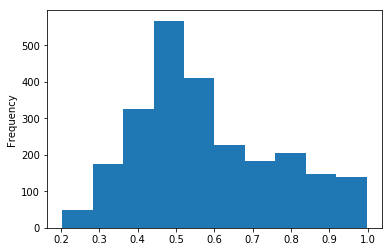

In [13]:
sel_to_check['predict_proba'].plot.hist(bins= 10) # 概率分布

#### all

#### predict_label

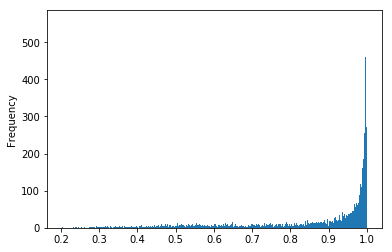

In [77]:
kfold_result['predict_proba'].plot.hist(bins = 1000)

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,class_sum,class_cumsum,class_pc,class_cumpc
predict_label,,,,,,,,,,,,,
1,0.000,13.000,39.000,122.000,128.000,150.000,227.000,460.000,757.000,1896.000,1896.000,0.137,0.137
2,0.000,22.000,75.000,112.000,137.000,152.000,188.000,406.000,633.000,1725.000,3621.000,0.124,0.261
3,4.000,25.000,25.000,44.000,60.000,53.000,78.000,150.000,205.000,644.000,4265.000,0.046,0.308
4,3.000,9.000,29.000,67.000,74.000,92.000,97.000,201.000,374.000,946.000,5211.000,0.068,0.376
5,6.000,37.000,82.000,129.000,116.000,127.000,134.000,278.000,769.000,1678.000,6889.000,0.121,0.497
6,2.000,19.000,30.000,61.000,65.000,74.000,115.000,271.000,1056.000,1693.000,8582.000,0.122,0.619
7,4.000,16.000,43.000,72.000,61.000,56.000,69.000,184.000,1086.000,1591.000,10173.000,0.115,0.734
8,1.000,29.000,75.000,163.000,176.000,203.000,256.000,483.000,2297.000,3683.000,13856.000,0.266,1.000
proba_sum,20.000,170.000,398.000,770.000,817.000,907.000,1164.000,2433.000,7177.000,13856.000,54493.000,1.000,3.933


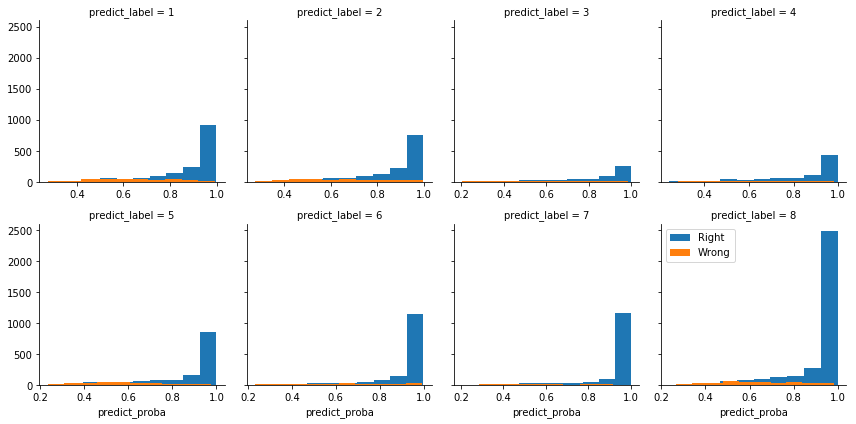

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x:'%.3f' %x)

sel_data = pd.DataFrame()
sel_data['predict_label'] = kfold_result['predict_label'].tolist()
sel_data['predict_proba'] = kfold_result['predict_proba'].tolist()
sel_data['label'] = kfold_result['label'].tolist()
sel_data['R_W'] = kfold_result['R_W'].tolist()
sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:str(round(x, 1))[:4])
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}

sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
sel_data['label'] = sel_data['label'].apply(lambda x:label_dic[x])
g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False, hue = 'R_W')
g.map(plt.hist, "predict_proba", bins = 10)
plt.legend()

sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
sel_data_stat['class_sum'] = sel_data_stat.sum(axis = 1)
num = sel_data_stat['class_sum'].sum()
sel_data_stat['class_cumsum'] = sel_data_stat['class_sum'].cumsum()
sel_data_stat['class_pc'] = sel_data_stat['class_sum'] / num
sel_data_stat['class_cumpc'] = sel_data_stat['class_cumsum'] / num
sel_data_stat.loc['proba_sum'] = sel_data_stat.sum(axis = 0)
sel_data_stat.loc['proba_cumsum'] = sel_data_stat.loc['proba_sum'].cumsum()
sel_data_stat.loc['proba_pc'] = sel_data_stat.loc['proba_sum'] / num
sel_data_stat.loc['proba_cumpc'] = sel_data_stat.loc['proba_cumsum'] / num
sel_data_stat

In [137]:
p_t = sel_data.pivot_table(index = ['predict_label'], columns = ['R_W'], 
                               values = ['label'], aggfunc = [len], 
                               fill_value=None, margins=True)
p_t['len', 'label', 'Right_rate'] = p_t['len', 'label', 'Right'] / p_t['len', 'label', 'All']
p_t['len', 'label', 'Wrong_rate'] = p_t['len', 'label', 'Wrong'] / p_t['len', 'label', 'All']
p_t['len', 'label', 'class_rate'] = p_t['len', 'label', 'All'] / sel_data.shape[0]
p_t

len                                              
               label                                              
R_W            Right Wrong    All Right_rate Wrong_rate class_rate
predict_label                                                     
1               1587   309   1896      0.837      0.163      0.137
2               1419   306   1725      0.823      0.177      0.124
3                553    91    644      0.859      0.141      0.046
4                814   132    946      0.860      0.140      0.068
5               1408   270   1678      0.839      0.161      0.121
6               1515   178   1693      0.895      0.105      0.122
7               1478   113   1591      0.929      0.071      0.115
8               3325   358   3683      0.903      0.097      0.266
All            12099  1757  13856      0.873      0.127      1.000

#### label

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,class_sum,class_cumsum,class_pc,class_cumpc
label,,,,,,,,,,,,,
1,1.000,12.000,36.000,112.000,123.000,125.000,200.000,448.000,757.000,1814.000,1814.000,0.131,0.131
2,0.000,23.000,67.000,124.000,144.000,156.000,201.000,406.000,634.000,1755.000,3569.000,0.127,0.258
3,3.000,34.000,34.000,55.000,72.000,68.000,90.000,163.000,208.000,727.000,4296.000,0.052,0.310
4,4.000,14.000,34.000,74.000,85.000,102.000,96.000,207.000,376.000,992.000,5288.000,0.072,0.382
5,3.000,25.000,80.000,115.000,101.000,124.000,149.000,285.000,768.000,1650.000,6938.000,0.119,0.501
6,2.000,14.000,26.000,57.000,51.000,61.000,100.000,247.000,1049.000,1607.000,8545.000,0.116,0.617
7,4.000,20.000,47.000,81.000,74.000,65.000,66.000,187.000,1090.000,1634.000,10179.000,0.118,0.735
8,3.000,28.000,74.000,152.000,167.000,206.000,262.000,490.000,2295.000,3677.000,13856.000,0.265,1.000
proba_sum,20.000,170.000,398.000,770.000,817.000,907.000,1164.000,2433.000,7177.000,13856.000,54485.000,1.000,3.932


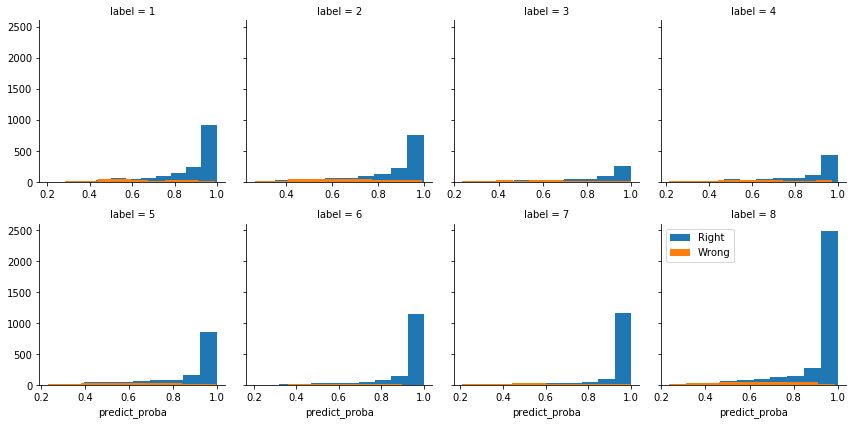

In [106]:
pd.set_option('display.float_format', lambda x:'%.3f' %x)
g = sns.FacetGrid(sel_data, col="label", col_wrap=4, sharex=False, hue = 'R_W')
g.map(plt.hist, "predict_proba", bins = 10)
plt.legend()

sel_data_stat = sel_data.groupby(['label', 'proba'])['predict_proba'].count().unstack().fillna(0)
sel_data_stat['class_sum'] = sel_data_stat.sum(axis = 1)
num = sel_data_stat['class_sum'].sum()
sel_data_stat['class_cumsum'] = sel_data_stat['class_sum'].cumsum()
sel_data_stat['class_pc'] = sel_data_stat['class_sum'] / num
sel_data_stat['class_cumpc'] = sel_data_stat['class_cumsum'] / num
sel_data_stat.loc['proba_sum'] = sel_data_stat.sum(axis = 0)
sel_data_stat.loc['proba_cumsum'] = sel_data_stat.loc['proba_sum'].cumsum()
sel_data_stat.loc['proba_pc'] = sel_data_stat.loc['proba_sum'] / num
sel_data_stat.loc['proba_cumpc'] = sel_data_stat.loc['proba_cumsum'] / num
sel_data_stat

In [138]:
test = kfold_result.iloc[:15, :]
test.head()

,raw_title,raw_content,label,predict_label,title_content,predict_proba,R_W
0,天安销售虚列费用为员工发福利 相关负责人被处罚,天安销售虚列费用为员工发福利 相关负责人被处罚\n\r2018.01.09 11:24:2...,公司内部管理,公司内部管理,天安 销售 虚列费用 为 员工 发 福利 相关 负责人 被 处罚 天安 销售 虚列费用 为 ...,0.995,Right
1,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元,泰康人寿疑设招聘骗局：3500元底薪扣到剩1200元\n\r 泰康人寿被爆疑设招聘“骗局...,公司内部管理,公司内部管理,泰康人寿 疑设 招聘 骗局 元 底薪 扣到 剩 元 泰康人寿 疑设 招聘 骗局 元 底薪 扣...,0.856,Right
2,上海人寿整改应对监管 万能险收紧后仍过保费半数,上海人寿屡被监管关照 万能险收紧后仍占半壁江山\n\r(图片)\n\r投资时报\n\r01...,公司内部管理,公司内部管理,上海人寿 整改 应对 监管 万能险 收紧 后 仍 过 保费 半数 上海人寿 屡 被 监管 关...,0.981,Right
3,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度,“侨兴债”事件继续发酵，浙商财险9位高管被问责 保监会加大“双罚制”执行力度\n\r0\n...,公司内部管理,公司内部管理,侨兴 债 事件 继续 发酵 浙商财险 位 高管 被 问责 保监会 加大 双罚制 执行 力度 ...,0.890,Right
4,“开门红”时期监管严查销售误导 民生人寿连吃5罚单,“开门红”时期监管严查销售误导 民生人寿连吃5罚单\n\r2018.01.09 01:22...,公司内部管理,公司内部管理,开门红 时期 监管 严查 销售误导 民生人寿 连 吃 罚单 开门红 时期 监管 严查 销售误...,0.928,Right


In [142]:
pd.DataFrame(tmp).T

,raw_title,raw_content,label,predict_label,title_content,predict_proba,R_W
14,中国人寿南通分公司违法内控不严 江苏保监出两罚单,原标题：中国人寿南通分公司违法内控不严 江苏保监出两罚单[新闻页-台海网] 5月22日，银...,公司内部管理,公司内部管理,中国人寿 南通 分公司 违法 内控 不严 江苏 保监 出 两 罚单 原 标题 中国人寿 南通...,0.991,Right


In [143]:
for index in test.index:
    tmp = pd.DataFrame(test.loc[index]).T
    print(tmp.shape)
    print(type(tmp))

(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>
(1, 7)
<class 'pandas.core.frame.DataFrame'>


#### Wrong

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,class_wrong_sum,class_wrong_pc
predict_label,,,,,,,,,,,
1,0.000,9.000,27.000,62.000,54.000,51.000,58.000,37.000,11.000,309.000,0.176
2,0.000,13.000,39.000,58.000,57.000,52.000,36.000,36.000,15.000,306.000,0.174
3,3.000,13.000,12.000,17.000,16.000,8.000,9.000,6.000,7.000,91.000,0.052
4,0.000,6.000,17.000,24.000,24.000,18.000,15.000,17.000,11.000,132.000,0.075
5,4.000,27.000,40.000,59.000,51.000,35.000,28.000,18.000,8.000,270.000,0.154
6,1.000,12.000,19.000,28.000,28.000,24.000,25.000,31.000,10.000,178.000,0.101
7,3.000,10.000,24.000,23.000,16.000,8.000,17.000,8.000,4.000,113.000,0.064
8,0.000,19.000,42.000,79.000,62.000,58.000,54.000,35.000,9.000,358.000,0.204
proba_wrong_sum,11.000,109.000,220.000,350.000,308.000,254.000,242.000,188.000,75.000,1757.000,1.000


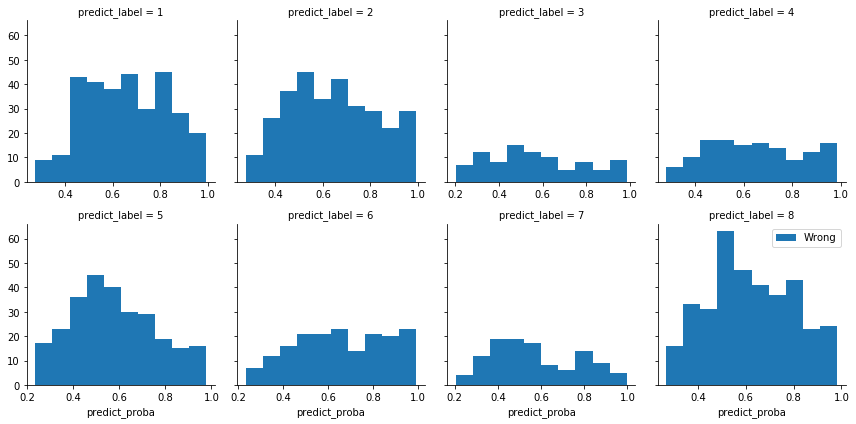

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x:'%.3f' %x)

sel_data = pd.DataFrame()
sel_data['predict_label'] = kfold_result[kfold_result['R_W'] == 'Wrong']['predict_label'].tolist()
sel_data['predict_proba'] = kfold_result[kfold_result['R_W'] == 'Wrong']['predict_proba'].tolist()
sel_data['label'] = kfold_result[kfold_result['R_W'] == 'Wrong']['label'].tolist()
sel_data['R_W'] = kfold_result[kfold_result['R_W'] == 'Wrong']['R_W'].tolist()
sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:str(round(x, 1))[:4])
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}

sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
sel_data['label'] = sel_data['label'].apply(lambda x:label_dic[x])
g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False, hue = 'R_W')
g.map(plt.hist, "predict_proba", bins = 10)
plt.legend()

sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
sel_data_stat['class_wrong_sum'] = sel_data_stat.sum(axis = 1)
num = sel_data_stat['class_wrong_sum'].sum()
# sel_data_stat['class_cumsum'] = sel_data_stat['class_wrong_sum'].cumsum()
sel_data_stat['class_wrong_pc'] = sel_data_stat['class_wrong_sum'].astype(int) / num
# sel_data_stat['class_cumpc'] = sel_data_stat['class_cumsum'] / num
sel_data_stat.loc['proba_wrong_sum'] = sel_data_stat.sum(axis = 0)
# sel_data_stat.loc['proba_cumsum'] = sel_data_stat.loc['proba_wrong_sum'].cumsum()
sel_data_stat.loc['proba_wron_pc'] = sel_data_stat.loc['proba_wrong_sum'] / num
# sel_data_stat.loc['proba_cumpc'] = sel_data_stat.loc['proba_cumsum'] / num
sel_data_stat

#### Right

proba,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,class_right_sum,class_right_pc
predict_label,,,,,,,,,,,
1,0.000,4.000,12.000,60.000,74.000,99.000,169.000,423.000,746.000,1587.000,0.131
2,0.000,9.000,36.000,54.000,80.000,100.000,152.000,370.000,618.000,1419.000,0.117
3,1.000,12.000,13.000,27.000,44.000,45.000,69.000,144.000,198.000,553.000,0.046
4,3.000,3.000,12.000,43.000,50.000,74.000,82.000,184.000,363.000,814.000,0.067
5,2.000,10.000,42.000,70.000,65.000,92.000,106.000,260.000,761.000,1408.000,0.116
6,1.000,7.000,11.000,33.000,37.000,50.000,90.000,240.000,1046.000,1515.000,0.125
7,1.000,6.000,19.000,49.000,45.000,48.000,52.000,176.000,1082.000,1478.000,0.122
8,1.000,10.000,33.000,84.000,114.000,145.000,202.000,448.000,2288.000,3325.000,0.275
proba_right_sum,9.000,61.000,178.000,420.000,509.000,653.000,922.000,2245.000,7102.000,12099.000,1.000


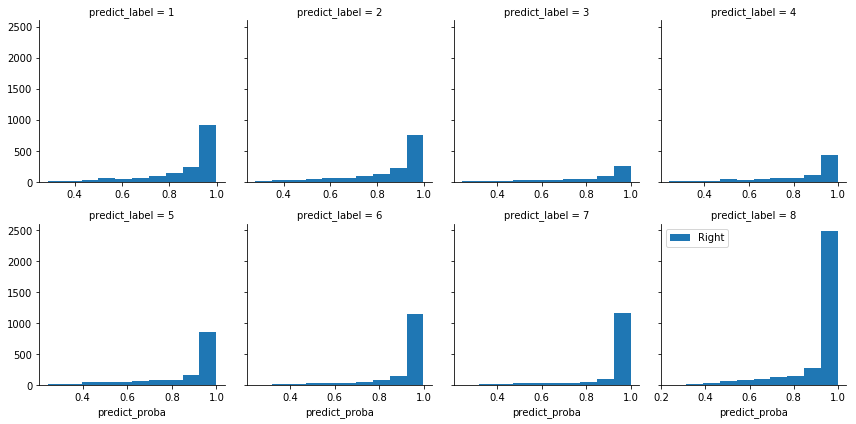

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x:'%.3f' %x)

sel_data = pd.DataFrame()
sel_data['predict_label'] = kfold_result[kfold_result['R_W'] == 'Right']['predict_label'].tolist()
sel_data['predict_proba'] = kfold_result[kfold_result['R_W'] == 'Right']['predict_proba'].tolist()
sel_data['label'] = kfold_result[kfold_result['R_W'] == 'Right']['label'].tolist()
sel_data['R_W'] = kfold_result[kfold_result['R_W'] == 'Right']['R_W'].tolist()
sel_data['proba'] = sel_data['predict_proba'].apply(lambda x:str(round(x, 1))[:4])
label_dic={'监管':1,'行业':2,'产品销售':3,'资本市场':4,'公司内部管理':5,'消费服务':6,'其他相关报道':7,'噪音':8}

sel_data['predict_label'] = sel_data['predict_label'].apply(lambda x:label_dic[x])
sel_data['label'] = sel_data['label'].apply(lambda x:label_dic[x])
g = sns.FacetGrid(sel_data, col="predict_label", col_wrap=4, sharex=False, hue = 'R_W')
g.map(plt.hist, "predict_proba", bins = 10)
plt.legend()

sel_data_stat = sel_data.groupby(['predict_label', 'proba'])['predict_proba'].count().unstack().fillna(0)
sel_data_stat['class_right_sum'] = sel_data_stat.sum(axis = 1)
num = sel_data_stat['class_right_sum'].sum()
# sel_data_stat['class_cumsum'] = sel_data_stat['class_right_sum'].cumsum()
sel_data_stat['class_right_pc'] = sel_data_stat['class_right_sum'].astype(int) / num
# sel_data_stat['class_cumpc'] = sel_data_stat['class_cumsum'] / num
sel_data_stat.loc['proba_right_sum'] = sel_data_stat.sum(axis = 0)
# sel_data_stat.loc['proba_cumsum'] = sel_data_stat.loc['proba_right_sum'].cumsum()
sel_data_stat.loc['proba_right_pc'] = sel_data_stat.loc['proba_right_sum'] / num
# sel_data_stat.loc['proba_cumpc'] = sel_data_stat.loc['proba_cumsum'] / num
sel_data_stat

# 其他模型-单一模型

## DecisionTreeClassifier

In [46]:
from sklearn.tree import DecisionTreeClassifier

In [47]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', DecisionTreeClassifier(max_depth = 7, random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.7012692050768203


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...         min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best'))])

In [48]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.67643391521197
             precision    recall  f1-score   support

          1       0.62      0.81      0.70       377
          2       0.67      0.43      0.53       283
          3       0.67      0.06      0.10       145
          4       0.21      0.74      0.33       201
          5       0.92      0.49      0.64       318
          6       0.90      0.75      0.82       434
          7       0.93      0.70      0.80       434
          8       0.83      0.79      0.81      1016

avg / total       0.78      0.68      0.69      3208

confusion_matrix: 
[[304  17   0  28   1   0   1  26]
 [ 35 123   0  77   3   8   2  35]
 [  0   5   8  86   0   9   3  34]
 [ 21   6   0 148   1   0   1  24]
 [ 12  18   0 122 156   3   2   5]
 [  4   6   2  57   0 327   9  29]
 [  7   1   0  95   9   7 303  12]
 [107   8   2  84   0   9   5 801]]


## SVC

In [49]:
from sklearn.svm import SVC

In [50]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', SVC(random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9807615230460922


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...bf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False))])

In [51]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7805486284289277
             precision    recall  f1-score   support

          1       0.84      0.81      0.82       377
          2       0.85      0.62      0.72       283
          3       0.86      0.45      0.59       145
          4       0.40      0.73      0.52       201
          5       0.92      0.67      0.78       318
          6       0.91      0.85      0.88       434
          7       0.92      0.85      0.89       434
          8       0.74      0.85      0.79      1016

avg / total       0.81      0.78      0.79      3208

confusion_matrix: 
[[304  11   2  24   2   1   1  32]
 [ 17 176   4  10  10   7   9  50]
 [  3   2  65  20   2   6   1  46]
 [  3   4   0 146   3   0   0  45]
 [  7  10   1  20 214   3   9  54]
 [  0   1   0  15   1 371   3  43]
 [  2   2   1  22   0   7 369  31]
 [ 28   1   3 104   0  14   7 859]]


## Perceptron

In [52]:
from sklearn.linear_model import Perceptron

In [53]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', Perceptron())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9947895791583167


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...n_jobs=1, penalty=None, random_state=0,
      shuffle=True, tol=None, verbose=0, warm_start=False))])

In [54]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.82356608478803
             precision    recall  f1-score   support

          1       0.78      0.85      0.81       377
          2       0.68      0.74      0.71       283
          3       0.70      0.74      0.72       145
          4       0.75      0.85      0.79       201
          5       0.82      0.72      0.77       318
          6       0.85      0.88      0.87       434
          7       0.87      0.86      0.87       434
          8       0.89      0.83      0.86      1016

avg / total       0.83      0.82      0.82      3208

confusion_matrix: 
[[321  18   4   6   2   2   2  22]
 [ 21 209   7   7  14   9   8   8]
 [  3   5 108   0   3   6   4  16]
 [  6   5   1 170   3   0   0  16]
 [ 14  27   4   6 229   8  12  18]
 [  3  10  11   2   5 384   6  13]
 [  5  15   6   6   7  13 374   8]
 [ 39  17  14  31  16  30  22 847]]


## LogisticRegression

In [55]:
from sklearn.linear_model import LogisticRegression

In [56]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', LogisticRegression(C=1000.0, random_state=0))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

1.0


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...nalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [57]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8366583541147132
             precision    recall  f1-score   support

          1       0.76      0.85      0.80       377
          2       0.70      0.68      0.69       283
          3       0.80      0.62      0.70       145
          4       0.77      0.80      0.79       201
          5       0.83      0.77      0.80       318
          6       0.89      0.91      0.90       434
          7       0.91      0.89      0.90       434
          8       0.87      0.88      0.88      1016

avg / total       0.84      0.84      0.84      3208

confusion_matrix: 
[[319  22   2   4   5   1   2  22]
 [ 28 192   6  11  15  10   7  14]
 [  1   9  90   1   7   7   1  29]
 [  8   9   0 161   3   0   1  19]
 [ 13  16   2   8 244   5   7  23]
 [  1  10   2   0   3 394   6  18]
 [  7   5   5   4   9   7 388   9]
 [ 41  13   5  19   8  20  14 896]]


## KNeighborsClassifier

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', KNeighborsClassifier())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.33587174348697396


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...owski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])

In [60]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.2696384039900249
             precision    recall  f1-score   support

          1       0.14      0.99      0.24       377
          2       0.87      0.14      0.24       283
          3       0.75      0.04      0.08       145
          4       0.94      0.16      0.27       201
          5       0.96      0.35      0.51       318
          6       0.97      0.08      0.14       434
          7       0.97      0.26      0.41       434
          8       0.98      0.16      0.27      1016

avg / total       0.85      0.27      0.28      3208

confusion_matrix: 
[[372   1   1   1   1   0   0   1]
 [241  39   1   0   2   0   0   0]
 [138   0   6   0   0   0   0   1]
 [169   0   0  32   0   0   0   0]
 [198   4   0   0 112   0   3   1]
 [399   1   0   0   0  34   0   0]
 [320   0   0   0   1   0 112   1]
 [854   0   0   1   1   1   1 158]]


## GaussianNB
- 高斯朴素贝叶斯（Gaussian Naive Bayes）
- 多项式朴素贝叶斯（Multinomial Naive Bayes）
- 伯努利朴素贝叶斯（ Bernoulli Naive Bayes）

In [61]:
from sklearn.naive_bayes import GaussianNB

In [62]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [63]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('to_dense', DenseTransformer()),
    ('classifier', GaussianNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9758183032732131


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...se', <__main__.DenseTransformer object at 0x7f770491c320>), ('classifier', GaussianNB(priors=None))])

In [64]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7253740648379052
             precision    recall  f1-score   support

          1       0.76      0.68      0.72       377
          2       0.58      0.58      0.58       283
          3       0.63      0.57      0.60       145
          4       0.72      0.74      0.73       201
          5       0.81      0.63      0.71       318
          6       0.87      0.69      0.77       434
          7       0.87      0.65      0.74       434
          8       0.67      0.88      0.76      1016

avg / total       0.74      0.73      0.72      3208

confusion_matrix: 
[[255  28  13  15   8   0   0  58]
 [ 24 163   7   8  12   7   9  53]
 [  2   8  83   0   3   5   1  43]
 [  6   4   1 149   4   0   0  37]
 [ 12  35   2   8 201   1   7  52]
 [  0  11   8   0   3 301  13  98]
 [  8  14   6   4  12  10 282  98]
 [ 27  20  12  23   6  21  14 893]]


In [65]:
from sklearn.naive_bayes import MultinomialNB

In [66]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    #('standard', StandardScaler(with_mean=False)),
    ('classifier', MultinomialNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.72812291249165


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...nsformer_weights=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [67]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.7188279301745636
             precision    recall  f1-score   support

          1       0.72      0.70      0.71       377
          2       0.48      0.67      0.56       283
          3       0.55      0.61      0.58       145
          4       0.75      0.80      0.78       201
          5       0.74      0.63      0.68       318
          6       0.74      0.89      0.81       434
          7       0.62      0.92      0.74       434
          8       0.96      0.61      0.75      1016

avg / total       0.76      0.72      0.72      3208

confusion_matrix: 
[[265  53   1   7  21   1  28   1]
 [ 14 189  11   6  24  11  22   6]
 [  0  15  88   0   1  24  15   2]
 [ 12  14   0 161   6   1   6   1]
 [  8  47   3   1 199   7  45   8]
 [  3  10   7   0   3 388  22   1]
 [  1  10   5   1   7   8 398   4]
 [ 64  55  44  38   7  84 106 618]]


In [68]:
from sklearn.naive_bayes import BernoulliNB

In [69]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', BernoulliNB())
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.7238476953907815


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9..._std=True)), ('classifier', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [70]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.6942019950124688
             precision    recall  f1-score   support

          1       0.70      0.67      0.68       377
          2       0.54      0.58      0.56       283
          3       0.56      0.61      0.58       145
          4       0.75      0.71      0.73       201
          5       0.74      0.59      0.66       318
          6       0.80      0.88      0.84       434
          7       0.47      0.91      0.62       434
          8       0.98      0.61      0.75      1016

avg / total       0.76      0.69      0.70      3208

confusion_matrix: 
[[253  31   5   6  18   1  62   1]
 [ 16 165   8   7  23   6  55   3]
 [  1   4  89   0   1  13  36   1]
 [  5   8   0 143   6   0  39   0]
 [  9  54   2   1 188   4  56   4]
 [  1   2   7   0   1 380  41   2]
 [  0  16   6   2   5   8 393   4]
 [ 79  25  43  32  11  62 148 616]]


# 其他模型-组合模型

## Bagging算法
- 使用训练样本的不同子集来建立多个模型（一般是相同类型）
- Bootstrap Aggregation或者叫bagging，从你的训练集多次抽样，在每个样本上进行模型。最后的输出是所有子模型的预测的平均结果。
> - Bagged决策树
    - > Bagging最适合那些具有高度变异的算法。很常用的一个例子就是决策树（不进行剪枝）。
    - > 以下的例子使用 BaggingClassifier和the Classification and Regression Trees 算法 (DecisionTreeClassifier), 创建有100个树的模型。
> - 随机森林    
    - > 随机森林是bagged决策树的一个扩展。从训练样本中可放回的抽样，构建决策树，但是要减少每个分类器之间的相关。就是说，不是贪婪地选取最佳的分割点，而是随机地选择特征子集建立分界点。你可以使用RandomForestClassifier类来构建随机森林模型。 
> - Extra Trees
    - > Extra Trees 也是Bagging方法的一个修正版。使用训练样本直接构建随机树。你可以使用ExtraTreesClassifier类构建Extra Trees。

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [72]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9930527722110889


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9... n_estimators=10, n_jobs=1, oob_score=False,
         random_state=7, verbose=0, warm_start=False))])

In [73]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8369700748129676
             precision    recall  f1-score   support

          1       0.76      0.88      0.81       377
          2       0.71      0.65      0.68       283
          3       0.73      0.66      0.69       145
          4       0.82      0.77      0.79       201
          5       0.79      0.79      0.79       318
          6       0.89      0.89      0.89       434
          7       0.88      0.90      0.89       434
          8       0.89      0.88      0.88      1016

avg / total       0.84      0.84      0.84      3208

confusion_matrix: 
[[332  17   0   2   3   1   3  19]
 [ 30 183   6   4  25  10   4  21]
 [  2   8  96   1   3  11   8  16]
 [ 10   8   0 154   6   2   3  18]
 [  7  16   6   7 251   9   9  13]
 [  3   3  12   2   6 386  12  10]
 [  4   5   6   2  12   3 392  10]
 [ 51  16   6  15  10  13  14 891]]


In [74]:
from sklearn.ensemble import RandomForestClassifier 

In [75]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', RandomForestClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9973279893119572


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...estimators=10, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False))])

In [76]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8148379052369077
             precision    recall  f1-score   support

          1       0.70      0.86      0.77       377
          2       0.68      0.63      0.65       283
          3       0.77      0.59      0.66       145
          4       0.81      0.72      0.76       201
          5       0.85      0.71      0.77       318
          6       0.89      0.91      0.90       434
          7       0.88      0.88      0.88       434
          8       0.84      0.87      0.85      1016

avg / total       0.82      0.81      0.81      3208

confusion_matrix: 
[[326  17   1   1   3   1   4  24]
 [ 38 177   7   5  10   6   9  31]
 [  2   6  85   3   2  14   6  27]
 [ 10  15   0 144   7   1   2  22]
 [ 20  22   5   2 225   7  13  24]
 [  4   6   5   2   1 396   5  15]
 [  6   4   3   1   7   8 380  25]
 [ 62  12   5  19   9  14  14 881]]


In [77]:
from sklearn.ensemble import ExtraTreesClassifier

In [78]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', ExtraTreesClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

1.0


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9..._estimators=10, n_jobs=1,
           oob_score=False, random_state=7, verbose=0, warm_start=False))])

In [79]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8188902743142145
             precision    recall  f1-score   support

          1       0.72      0.85      0.78       377
          2       0.72      0.65      0.69       283
          3       0.80      0.54      0.64       145
          4       0.84      0.78      0.81       201
          5       0.87      0.72      0.78       318
          6       0.88      0.90      0.89       434
          7       0.89      0.88      0.89       434
          8       0.81      0.87      0.84      1016

avg / total       0.82      0.82      0.82      3208

confusion_matrix: 
[[321  12   1   4   3   0   5  31]
 [ 29 185   5   5  13   5   8  33]
 [  2   9  78   0   0  15   5  36]
 [  5   9   0 157   7   2   1  20]
 [ 18  19   5   1 228   4  10  33]
 [  6   2   3   1   2 389   4  27]
 [  8   5   2   2   5   7 382  23]
 [ 56  16   3  18   5  18  13 887]]


## Boosting算法
- Boosting集成算法创建一个模型序列，并试图矫正序列中该模型之前模型的错误。一旦模型被创建，模型使用单个模型的准确率作为权重进行整体的预测。
> - AdaBoost
    - > AdaBoost 大概是第一个有效的boosting算法. 一般根据具体实例是否容易被预测给其添加权重，当进行后续模型构建的时候根据权重对该实例进行处理。你可以使用AdaBoostClassifier类构建AdaBoost模型。
> - Stochastic Gradient Boosting
    - > Stochastic Gradient Boosting是最为精细的模型集成技术。它也可能是最有效的提升模型表现的集成技术。你可以使用 GradientBoostingClassifier类构建Gradient Boosting模型。

In [80]:
from sklearn.ensemble import AdaBoostClassifier

In [81]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', AdaBoostClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.690313961255845


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...ithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=7))])

In [82]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.6864089775561097
             precision    recall  f1-score   support

          1       0.61      0.71      0.66       377
          2       0.55      0.33      0.41       283
          3       0.43      0.37      0.39       145
          4       0.72      0.48      0.58       201
          5       0.44      0.55      0.49       318
          6       0.83      0.88      0.85       434
          7       0.83      0.66      0.73       434
          8       0.74      0.84      0.79      1016

avg / total       0.69      0.69      0.68      3208

confusion_matrix: 
[[267  20   1   4  18   0   6  61]
 [ 47  93  10  10  46  11   9  57]
 [  2   9  53   1  23  16   7  34]
 [ 15   6  12  97  36   0   2  33]
 [ 24  14   8   5 175   7  11  74]
 [  2   9  12   0   4 382  12  13]
 [ 15   4  21   3  57  24 285  25]
 [ 64  13   7  14  38  20  10 850]]


In [83]:
from sklearn.ensemble import GradientBoostingClassifier

In [84]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', GradientBoostingClassifier(random_state=7))
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9691382765531062


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...         presort='auto', random_state=7, subsample=1.0, verbose=0,
              warm_start=False))])

In [85]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.8678304239401496
             precision    recall  f1-score   support

          1       0.83      0.88      0.85       377
          2       0.77      0.72      0.74       283
          3       0.80      0.67      0.73       145
          4       0.86      0.84      0.85       201
          5       0.84      0.80      0.82       318
          6       0.90      0.93      0.92       434
          7       0.92      0.92      0.92       434
          8       0.89      0.91      0.90      1016

avg / total       0.87      0.87      0.87      3208

confusion_matrix: 
[[332  13   1   3   5   1   1  21]
 [ 15 203   5   4  10  13   6  27]
 [  1   6  97   1   6   8   4  22]
 [  5   6   0 168   6   0   1  15]
 [  6  20   4   4 254   8   6  16]
 [  2   5   4   0   3 404   8   8]
 [  4   0   4   0  10   5 401  10]
 [ 36  10   7  15   7   9   7 925]]


## Voting算法
- Voting是组合多个算法进行预测的一个最简单的方法。
- 首先使用你的训练集分别建立模型，Voting类用于组合你的模型，平均多个模型的结果来进行预测。
- 子模型的预测可以进行加权，但是手动的给分类器加上权重还是比较困难的。更为高级的方法是让模型自己学习给子模型加权。
- 这个所谓的stacked aggregation方法目前在 scikit-learn还不能实现。可以使用VotingClassifier类建立voting模型。
- 以下例子组合logistic 回归，分类和回归树以及SVM来进行预测。

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [87]:
clf1 = GradientBoostingClassifier()
clf2 = BernoulliNB()
clf3 = MultinomialNB()

estimators = [('gdbt', clf1), ('bnb', clf2), ('mnb', clf3)]
ensemble = VotingClassifier(estimators, n_jobs = -1, voting = 'soft')

In [88]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tf_idf', Pipeline([
            ('counts', CountVectorizer(max_df=0.95, min_df=2)),
            ('tf_idf', TfidfTransformer()),
            ('chi', SelectKBest(chi2, k=20000))
        ])),
        ('tf', Statskeywords(topk = 1000)),
        ('len_stats', StatsFeatures_cor())
    ])),
    ('standard', StandardScaler(with_mean=False)),
    ('classifier', ensemble)
])

pipeline.fit(X_train, y_train)
print(pipeline.score(X_train, y_train))
pipeline

0.9318637274549099


Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('tf_idf', Pipeline(memory=None,
     steps=[('counts', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9...=None, fit_prior=True))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None))])

In [89]:
y_pred_class = pipeline.predict(X_test)
print('accuracy_score: ', metrics.accuracy_score(y_test, y_pred_class)) # 指所有分类正确的百分比
print(metrics.classification_report(y_test, y_pred_class))
print('confusion_matrix: ')
print( metrics.confusion_matrix(y_test, y_pred_class))

accuracy_score:  0.830423940149626
             precision    recall  f1-score   support

          1       0.77      0.86      0.82       377
          2       0.68      0.75      0.72       283
          3       0.69      0.78      0.73       145
          4       0.77      0.88      0.82       201
          5       0.88      0.70      0.78       318
          6       0.89      0.91      0.90       434
          7       0.78      0.94      0.85       434
          8       0.94      0.80      0.86      1016

avg / total       0.84      0.83      0.83      3208

confusion_matrix: 
[[326  21   4   7   3   0   9   7]
 [ 17 212   8   6  14   6  14   6]
 [  1   7 113   0   2   4   8  10]
 [  6   9   0 177   4   0   3   2]
 [  9  39   4   2 223   5  25  11]
 [  2   5   4   0   2 395  19   7]
 [  1   2   7   1   2   5 407   9]
 [ 60  15  24  36   3  31  36 811]]


# 模型保存

In [93]:
# from sklearn.externals import joblib
# joblib.dump(pipeline, "model/circ_8classifier_0803.pkl.z")

['model/circ_8classifier_0803.pkl.z']

# 保存本文件

In [56]:
if 0:
    import datetime as dt
    
    def output_HTML(read_file, output_file):
        from nbconvert import HTMLExporter
        import codecs
        import nbformat
        exporter = HTMLExporter()
        # read_file is '.ipynb', output_file is '.html'
        output_notebook = nbformat.read(read_file, as_version=4)
        output, resources = exporter.from_notebook_node(output_notebook)
        codecs.open(output_file, 'w', encoding='utf-8').write(output)

    html_file_folder = 'html_files'
    if not os.path.exists(html_file_folder):
        os.makedirs(html_file_folder)

    today = dt.datetime.now().strftime('%Y%m%d')
    current_file = 'circ_cor_model_2_train.ipynb'
    output_file = 'html_files\%s_%s.html'%(os.path.splitext(current_file)[0], today)
    output_HTML(current_file, output_file)